## DAPP on DDR+APTOS, Pool Size 10

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import json
import time
import platform
from datetime import datetime

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("!" * 60)
    print(f"GPU:   {torch.cuda.get_device_name(0)}")
    print(f"VRAM:  {torch.cuda.get_device_properties(0).total_memory/1e9:.1f} GB")
    print("!" * 60)
    torch.backends.cudnn.benchmark     = True
    torch.backends.cudnn.deterministic = False
else:
    device = torch.device('cpu')
    print("WARNING: No GPU — running on CPU")

print(f"✓ Device: {device}")
print("✓ All imports complete")

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
GPU:   NVIDIA RTX A6000
VRAM:  51.0 GB
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
✓ Device: cuda
✓ All imports complete


In [ ]:

APTOS_PATH = "./train_images"    
DDR_PATH   = "./DR_grading/DR_grading"      

NUM_CLASSES  = 5
NUM_CLIENTS  = 5               
TRAIN_RATIO  = 0.8             
BATCH_SIZE   = 32
SEED         = 42

LABEL_NAMES  = ['NoDR', 'Mild', 'Moderate', 'Severe', 'Proliferative']

safe_workers = 0 if platform.system() == 'Windows' else 4
PIN_MEMORY   = torch.cuda.is_available()

print("=" * 60)
print("CONFIGURATION")
print("=" * 60)
print(f"  APTOS path   : {APTOS_PATH}")
print(f"  DDR path     : {DDR_PATH}")
print(f"  Clients each : {NUM_CLIENTS}  (total: {NUM_CLIENTS*2})")
print(f"  Train/Test   : {int(TRAIN_RATIO*100)}/{int((1-TRAIN_RATIO)*100)}")
print(f"  Batch size   : {BATCH_SIZE}")
print(f"  Workers      : {safe_workers}")
print("=" * 60)

CONFIGURATION
  APTOS path   : ./train_images
  DDR path     : ./DR_grading/DR_grading
  Clients each : 5  (total: 10)
  Train/Test   : 80/19
  Batch size   : 32
  Workers      : 4


In [ ]:
TRAIN_TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2,
                           saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

TEST_TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

print("✓ Transforms defined")

✓ Transforms defined


In [ ]:
class APTOSDataset(Dataset):
   
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels      = labels
        self.transform   = transform

    @classmethod
    def from_folder(cls, data_path="./data/aptos"):
        data_path = Path(data_path)
        img_dir   = data_path 

        if not img_dir.exists():
            raise FileNotFoundError(f"train_images/ not found at: {img_dir}")

        csv_path  = data_path / "train.csv"
        xlsx_path = data_path / "train.xlsx"

        if csv_path.exists():
            df = pd.read_csv(csv_path)
            print(f"  APTOS: reading {csv_path}")
        elif xlsx_path.exists():
            df = pd.read_excel(xlsx_path)
            print(f"  APTOS: reading {xlsx_path}")
        else:
            raise FileNotFoundError(
                f"Neither train.csv nor train.xlsx found in {data_path}"
            )

        print(f"  APTOS columns: {list(df.columns)}")
        print(f"  APTOS preview:\n{df.head(3).to_string()}")

        image_paths, labels_list = [], []
        skipped = 0

        for _, row in df.iterrows():
            img_path = img_dir / f"{row['id_code']}.png"

            if not img_path.exists():
                img_path_jpg = img_dir / f"{row['id_code']}.jpg"
                if img_path_jpg.exists():
                    img_path = img_path_jpg
                else:
                    skipped += 1
                    continue

            image_paths.append(img_path)
            labels_list.append(int(row['diagnosis']))

        print(f"\n  APTOS: {len(image_paths)} images loaded  "
              f"({skipped} skipped — file not found)")

        lbl_arr = np.array(labels_list)
        counts  = np.bincount(lbl_arr, minlength=NUM_CLASSES)
        total   = len(lbl_arr)
        print(f"  APTOS full distribution:")
        for i, (name, count) in enumerate(zip(LABEL_NAMES, counts)):
            pct = 100. * count / total
            print(f"    Class {i} ({name:13s}): {count:5d}  ({pct:5.1f}%)")

        return cls(image_paths, labels_list, transform=None)

    def __len__(self): return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert('RGB')
        except Exception:
            image = Image.new('RGB', (224, 224), color=(0, 0, 0))
        if self.transform:
            image = self.transform(image)
        return image, int(self.labels[idx])


print("✓ APTOSDataset defined")
print("  Reads train.csv only — test_images/ completely ignored")
print("  id_code + .png → full image path")

✓ APTOSDataset defined
  Reads train.csv only — test_images/ completely ignored
  id_code + .png → full image path


In [ ]:
class DDRDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels      = labels
        self.transform   = transform

    @classmethod
    def from_folder(cls, data_path="./data/ddr"):
        data_path = Path(data_path)
        img_dir   = data_path 

        if not img_dir.exists():
            raise FileNotFoundError(f"DR_grading/ not found at: {img_dir}")

        csv_path  = data_path / "DR_grading.csv"
        xlsx_path = data_path / "DR_grading.xlsx"

        if csv_path.exists():
            df = pd.read_csv(csv_path)
            print(f"  DDR: reading {csv_path}")
        elif xlsx_path.exists():
            df = pd.read_excel(xlsx_path)
            print(f"  DDR: reading {xlsx_path}")
        else:
            raise FileNotFoundError(
                f"Neither DR_grading.csv nor DR_grading.xlsx found in {data_path}"
            )

        print(f"  DDR columns: {list(df.columns)}")
        print(f"  DDR preview:\n{df.head(3).to_string()}")

      
        id_col    = 'id_code'
        label_col = 'diagnosis'

        if id_col not in df.columns or label_col not in df.columns:
            print(f"  ⚠ Expected 'id_code'/'diagnosis' not found")
            print(f"  ⚠ Actual columns: {list(df.columns)}")
            print(f"  ⚠ Trying auto-detect...")
            id_col    = df.columns[0]
            label_col = df.columns[1]
            print(f"  ⚠ Using: id='{id_col}'  label='{label_col}'")

        image_paths, labels_list = [], []
        skipped_nf = 0    
        skipped_ug = 0    

        for _, row in df.iterrows():
            label = int(row[label_col])

            if label > 4:
                skipped_ug += 1
                continue

            filename = str(row[id_col]).strip()
            img_path = img_dir / filename

            if not img_path.exists():
                skipped_nf += 1
                continue

            image_paths.append(img_path)
            labels_list.append(label)

        print(f"\n  DDR: {len(image_paths)} images loaded")
        print(f"       {skipped_ug} ungradable (label 5) dropped")
        print(f"       {skipped_nf} skipped — file not found")

        lbl_arr = np.array(labels_list)
        counts  = np.bincount(lbl_arr, minlength=NUM_CLASSES)
        total   = len(lbl_arr)
        print(f"  DDR full distribution:")
        for i, (name, count) in enumerate(zip(LABEL_NAMES, counts)):
            pct = 100. * count / total
            print(f"    Class {i} ({name:13s}): {count:5d}  ({pct:5.1f}%)")

        return cls(image_paths, labels_list, transform=None)

    def __len__(self): return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert('RGB')
        except Exception:
            image = Image.new('RGB', (224, 224), color=(0, 0, 0))
        if self.transform:
            image = self.transform(image)
        return image, int(self.labels[idx])


print("✓ DDRDataset defined")
print("  id_code already has .jpg extension — used directly")
print("  Label 5 (ungradable) automatically dropped")

✓ DDRDataset defined
  id_code already has .jpg extension — used directly
  Label 5 (ungradable) automatically dropped


In [27]:
# ============================================================================
# CELL 6: Stratified Federated Split — CORRECTED
# ============================================================================

def stratified_federated_split(dataset_cls,
                                image_paths,
                                labels,
                                num_clients=5,
                                train_ratio=0.8,
                                seed=42):
    """
    Splits into num_clients clients.
    Each client gets identical class distribution.
    Each client's train and test split also preserve class distribution.

    Parameters
    ----------
    dataset_cls  : APTOSDataset or DDRDataset
    image_paths  : list of Path objects
    labels       : list of int
    num_clients  : int
    train_ratio  : float  (0.8 = 80% train per client)
    seed         : int

    Returns
    -------
    List of dicts — one per client
    """
    np.random.seed(seed)
    labels_arr  = np.array(labels)
    image_paths = list(image_paths)

    # Step 1: Group indices by class
    class_indices = {}
    for cls in range(NUM_CLASSES):
        idx = np.where(labels_arr == cls)[0].tolist()
        np.random.shuffle(idx)
        class_indices[cls] = idx

    # Step 2: Distribute each class equally across clients
    client_pool = {k: [] for k in range(num_clients)}
    for cls in range(NUM_CLASSES):
        chunks = np.array_split(class_indices[cls], num_clients)
        for k, chunk in enumerate(chunks):
            client_pool[k].extend(chunk.tolist())

    clients = []

    for k in range(num_clients):
        pool        = np.array(client_pool[k])
        pool_labels = labels_arr[pool]

        # Step 3: Stratified 80/20 within each client's pool
        train_idx, test_idx = [], []
        for cls in range(NUM_CLASSES):
            cls_mask = np.where(pool_labels == cls)[0]
            cls_pool = pool[cls_mask]
            np.random.shuffle(cls_pool)
            n_train  = max(1, int(len(cls_pool) * train_ratio))
            train_idx.extend(cls_pool[:n_train].tolist())
            test_idx.extend( cls_pool[n_train:].tolist())

        np.random.shuffle(train_idx)
        np.random.shuffle(test_idx)

        train_labels = labels_arr[train_idx]
        test_labels  = labels_arr[test_idx]
        train_counts = np.bincount(train_labels, minlength=NUM_CLASSES)
        test_counts  = np.bincount(test_labels,  minlength=NUM_CLASSES)

        # Build dataset objects
        train_ds = dataset_cls(
            [image_paths[i] for i in train_idx],
            [int(labels_arr[i]) for i in train_idx],
            transform=TRAIN_TRANSFORM
        )
        test_ds = dataset_cls(
            [image_paths[i] for i in test_idx],
            [int(labels_arr[i]) for i in test_idx],
            transform=TEST_TRANSFORM
        )

        train_loader = DataLoader(
            train_ds, batch_size=BATCH_SIZE, shuffle=True,
            num_workers=safe_workers, pin_memory=PIN_MEMORY,
            persistent_workers=(safe_workers > 0)
        )
        test_loader = DataLoader(
            test_ds, batch_size=BATCH_SIZE, shuffle=False,
            num_workers=safe_workers, pin_memory=PIN_MEMORY,
            persistent_workers=(safe_workers > 0)
        )

        clients.append({
            'client_id'        : k,
            'train_dataset'    : train_ds,
            'test_dataset'     : test_ds,
            'train_loader'     : train_loader,
            'test_loader'      : test_loader,
            'train_size'       : len(train_ds),
            'test_size'        : len(test_ds),
            'label_counts'     : {int(c): int(train_counts[c])
                                  for c in range(NUM_CLASSES)},
            'test_label_counts': {int(c): int(test_counts[c])
                                  for c in range(NUM_CLASSES)},
        })

    return clients


print("✓ stratified_federated_split defined")

✓ stratified_federated_split defined


In [28]:
# ============================================================================
# CELL 7: Load Both Datasets
# ============================================================================

print("\n" + "=" * 60)
print("LOADING RAW DATASETS")
print("=" * 60)

print("\n[1/2] Loading APTOS...")
aptos_raw = APTOSDataset.from_folder(APTOS_PATH)

print("\n[2/2] Loading DDR...")
ddr_raw   = DDRDataset.from_folder(DDR_PATH)

print(f"\n✓ APTOS: {len(aptos_raw)} total samples")
print(f"✓ DDR:   {len(ddr_raw  )} total samples")


LOADING RAW DATASETS

[1/2] Loading APTOS...
  APTOS: reading train_images/train.csv
  APTOS columns: ['id_code', 'diagnosis']
  APTOS preview:
        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1

  APTOS: 3662 images loaded  (0 skipped — file not found)
  APTOS full distribution:
    Class 0 (NoDR         ):  1805  ( 49.3%)
    Class 1 (Mild         ):   370  ( 10.1%)
    Class 2 (Moderate     ):   999  ( 27.3%)
    Class 3 (Severe       ):   193  (  5.3%)
    Class 4 (Proliferative):   295  (  8.1%)

[2/2] Loading DDR...
  DDR: reading DR_grading/DR_grading/DR_grading.csv
  DDR columns: ['id_code', 'diagnosis']
  DDR preview:
                 id_code  diagnosis
0  20170413102628830.jpg          0
1  20170413111955404.jpg          0
2  20170413112015395.jpg          0

  DDR: 12522 images loaded
       0 ungradable (label 5) dropped
       0 skipped — file not found
  DDR full distribution:
    Class 0 (NoDR         ):  6266  ( 

In [ ]:
# ============================================================================
# CELL 8: Create 5 APTOS + 5 DDR Clients  — CORRECTED call signature
# ============================================================================

print("\n" + "=" * 60)
print("CREATING FEDERATED CLIENTS")
print("=" * 60)

print("\n[1/2] Splitting APTOS into 5 clients...")
aptos_clients = stratified_federated_split(
    dataset_cls = APTOSDataset,
    image_paths = aptos_raw.image_paths,
    labels      = aptos_raw.labels,
    num_clients = NUM_CLIENTS,
    train_ratio = TRAIN_RATIO,
    seed        = SEED
)

print("\n[2/2] Splitting DDR into 5 clients...")
ddr_clients = stratified_federated_split(
    dataset_cls = DDRDataset,
    image_paths = ddr_raw.image_paths,
    labels      = ddr_raw.labels,
    num_clients = NUM_CLIENTS,
    train_ratio = TRAIN_RATIO,
    seed        = SEED
)

# Global IDs:  APTOS = 0–4,  DDR = 5–9
for info in ddr_clients:
    info['client_id'] += NUM_CLIENTS

all_clients = aptos_clients + ddr_clients   # 10 total

print("\n" + "=" * 70)
print("ALL 10 CLIENTS READY")
print("=" * 70)
print(f"{'CID':<5} {'Source':<7} {'Train':>7} {'Test':>6}  "
      f"Train Class Distribution")
print("-" * 70)
for info in all_clients:
    source = "APTOS" if info['client_id'] < 5 else "DDR"
    dist   = "  ".join([
        f"C{k}:{v}" for k, v in info['label_counts'].items()
    ])
    print(f"  {info['client_id']:<3}  {source:<7} "
          f"{info['train_size']:>7} {info['test_size']:>6}  {dist}")
print("=" * 70)


CREATING FEDERATED CLIENTS

[1/2] Splitting APTOS into 5 clients...

[2/2] Splitting DDR into 5 clients...

ALL 10 CLIENTS READY
CID   Source    Train   Test  Train Class Distribution
----------------------------------------------------------------------
  0    APTOS       585    148  C0:288  C1:59  C2:160  C3:31  C4:47
  1    APTOS       585    148  C0:288  C1:59  C2:160  C3:31  C4:47
  2    APTOS       585    148  C0:288  C1:59  C2:160  C3:31  C4:47
  3    APTOS       584    148  C0:288  C1:59  C2:160  C3:30  C4:47
  4    APTOS       583    148  C0:288  C1:59  C2:159  C3:30  C4:47
  5    DDR        2003    504  C0:1003  C1:100  C2:716  C3:38  C4:146
  6    DDR        2001    504  C0:1002  C1:100  C2:716  C3:37  C4:146
  7    DDR        2001    503  C0:1002  C1:100  C2:716  C3:37  C4:146
  8    DDR        2000    503  C0:1002  C1:100  C2:716  C3:37  C4:145
  9    DDR        2000    503  C0:1002  C1:100  C2:716  C3:37  C4:145


In [ ]:
# ============================================================================
# CELL 9: Verify Distribution Is Consistent Across All Clients
# ============================================================================

print("\n" + "=" * 70)
print("DISTRIBUTION VERIFICATION")
print("=" * 70)
print("Checking that every client has roughly equal class proportions...\n")

print(f"{'CID':<5} {'Source':<7}", end="")
for name in LABEL_NAMES:
    print(f"  {name[:5]:>7}", end="")
print()
print("-" * 70)

for info in all_clients:
    source = "APTOS" if info['client_id'] < 5 else "DDR"
    total  = info['train_size']
    print(f"  {info['client_id']:<3}  {source:<7}", end="")
    for cls in range(NUM_CLASSES):
        n   = info['label_counts'].get(cls, 0)
        pct = 100. * n / total if total > 0 else 0
        print(f"  {pct:>6.1f}%", end="")
    print()

print("\n✓ If percentages are similar across rows → distribution is consistent")
print("  APTOS clients share one distribution")
print("  DDR clients share one distribution")
print("  (The two datasets may differ from each other — that is expected)")


DISTRIBUTION VERIFICATION
Checking that every client has roughly equal class proportions...

CID   Source      NoDR     Mild    Moder    Sever    Proli
----------------------------------------------------------------------
  0    APTOS      49.2%    10.1%    27.4%     5.3%     8.0%
  1    APTOS      49.2%    10.1%    27.4%     5.3%     8.0%
  2    APTOS      49.2%    10.1%    27.4%     5.3%     8.0%
  3    APTOS      49.3%    10.1%    27.4%     5.1%     8.0%
  4    APTOS      49.4%    10.1%    27.3%     5.1%     8.1%
  5    DDR        50.1%     5.0%    35.7%     1.9%     7.3%
  6    DDR        50.1%     5.0%    35.8%     1.8%     7.3%
  7    DDR        50.1%     5.0%    35.8%     1.8%     7.3%
  8    DDR        50.1%     5.0%    35.8%     1.9%     7.2%
  9    DDR        50.1%     5.0%    35.8%     1.9%     7.2%

✓ If percentages are similar across rows → distribution is consistent
  APTOS clients share one distribution
  DDR clients share one distribution
  (The two datasets may diffe

In [31]:
# ============================================================================
# CELL 10: Install timm
# ============================================================================

import subprocess, sys

try:
    import timm
    print(f"✓ timm already installed: {timm.__version__}")
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "timm", "-q"])
    import timm
    print(f"✓ timm installed: {timm.__version__}")

✓ timm already installed: 0.9.0


In [32]:
# ============================================================================
# CELL 11: ViT Backbone (Frozen)
# ============================================================================

import timm

class ViTBackbone(nn.Module):
    """
    ViT-Base/16 pretrained on ImageNet-21k.
    Fully FROZEN — no gradients ever flow through it.
    Used only as a fixed feature extractor.

    Output: 768-dim CLS token embedding per image.

    Why freeze:
      - Federated learning communicates only prompts (tiny)
      - Finetuning 86M params per client is expensive and unstable
      - Pretrained features are already strong for medical images
    """
    def __init__(self, pretrained=True):
        super().__init__()
        print("\n  Loading ViT-Base/16 (ImageNet-21k)...")

        # Load with head to extract pretrained weights
        vit_with_head = timm.create_model(
            'vit_base_patch16_224',
            pretrained=pretrained,
            num_classes=21843
        )

        self.embed_dim = 768

        # Extract pretrained head weights for classifier init later
        self.pretrained_head = None
        if pretrained and hasattr(vit_with_head, 'head'):
            head = vit_with_head.head
            if isinstance(head, nn.Linear):
                self.pretrained_head = {
                    'weight': head.weight.data.clone(),   # [21843, 768]
                    'bias'  : head.bias.data.clone()      # [21843]
                }
                print(f"  ✓ Pretrained head extracted: "
                      f"[{head.in_features} → {head.out_features}]")

        # Backbone without head — returns full token sequence
        self.vit = timm.create_model(
            'vit_base_patch16_224',
            pretrained=pretrained,
            num_classes=0,
            global_pool=''
        )

        # Freeze all backbone params
        for param in self.vit.parameters():
            param.requires_grad = False
        self.vit.eval()

        del vit_with_head

        total = sum(p.numel() for p in self.vit.parameters())
        print(f"  ✓ ViT-Base frozen: {total:,} params")
        print(f"  ✓ Output dim: {self.embed_dim}")

    def forward(self, x):
        with torch.no_grad():
            features = self.vit.forward_features(x)  # [B, 197, 768]
            cls_token = features[:, 0]                # [B, 768]
        return cls_token

    def get_feature_dim(self):       return self.embed_dim
    def has_pretrained_head(self):   return self.pretrained_head is not None
    def get_pretrained_head(self):   return self.pretrained_head


print("✓ ViTBackbone defined")
print("  Output: 768-dim CLS token (frozen)")

✓ ViTBackbone defined
  Output: 768-dim CLS token (frozen)


In [ ]:
# ============================================================================
# CELL 12: Client Descriptor Computer
# ============================================================================

class ClientDescriptorComputer:
    """
    Computes a fixed statistical descriptor for each client ONCE
    before federated training begins.

    Descriptor d_n = [mu_n | sigma_n | c_n]
                    = [768  |  768   |  5 ]
                    = 1541-dim vector

    Components:
      mu_n    — mean of all CLS features          → captures domain shift
      sigma_n — variance of all CLS features      → captures data diversity
      c_n     — normalized class distribution     → captures label imbalance
    """
    def __init__(self, backbone, num_classes=5, device='cpu'):
        self.backbone    = backbone
        self.num_classes = num_classes
        self.device      = torch.device(device) if isinstance(device, str) \
                           else device

    def compute_descriptor(self, train_loader, client_id=None):
        self.backbone.eval()
        all_features, all_labels = [], []

        prefix = f"Client {client_id}" if client_id is not None else ""
        print(f"  {prefix}: extracting features "
              f"({len(train_loader)} batches)...")

        with torch.no_grad():
            for images, labels in tqdm(train_loader,
                                       desc=f"    {prefix}",
                                       leave=False):
                images = images.to(self.device)
                feats  = self.backbone(images)          # [B, 768]
                all_features.append(feats.cpu())
                all_labels.append(labels.cpu())

        all_features = torch.cat(all_features, dim=0)  # [N, 768]
        all_labels   = torch.cat(all_labels,   dim=0)  # [N]

        mu_n    = all_features.mean(dim=0)              # [768]
        sigma_n = all_features.var (dim=0, unbiased=True) # [768]

        counts = torch.zeros(self.num_classes)
        for lbl in all_labels:
            counts[int(lbl.item())] += 1
        c_n = counts / counts.sum()                    # [5]

        descriptor = torch.cat([mu_n, sigma_n, c_n])  # [1541]

        print(f"  {prefix}: descriptor shape = {descriptor.shape}")
        print(f"    mu    range: [{mu_n.min():.3f}, {mu_n.max():.3f}]")
        print(f"    sigma range: [{sigma_n.min():.3f}, {sigma_n.max():.3f}]")
        print(f"    c_n  (class dist): {c_n.numpy().round(3)}")

        return descriptor


print("✓ ClientDescriptorComputer defined")
print("  Descriptor dim: 768 + 768 + 5 = 1541")

✓ ClientDescriptorComputer defined
  Descriptor dim: 768 + 768 + 5 = 1541


In [34]:
# ============================================================================
# CELL 13: Prompt Pool
# ============================================================================

class PromptPool(nn.Module):
    """
    Server-side shared pool of M prompt templates.

    Shape: [pool_size, prompt_length, embed_dim]
         = [10,        5,             768       ]

    All clients share the same pool but SELECT differently
    based on their descriptor — that is the personalization.

    Prompts are updated every round via weighted aggregation
    of client prompt deltas.
    """
    def __init__(self, pool_size=10, prompt_length=5, embed_dim=768):
        super().__init__()
        self.pool_size     = pool_size
        self.prompt_length = prompt_length
        self.embed_dim     = embed_dim

        # Small random init — important for stable early training
        self.prompts = nn.Parameter(
            torch.randn(pool_size, prompt_length, embed_dim) * 0.02
        )

        total = self.prompts.numel()
        print(f"  PromptPool: [{pool_size}, {prompt_length}, {embed_dim}]")
        print(f"  Total params: {total:,}")

    def forward(self):
        """Return full prompt pool tensor."""
        return self.prompts


print("✓ PromptPool defined")
print("  Shape: [pool_size=10, prompt_length=5, embed_dim=768]")

✓ PromptPool defined
  Shape: [pool_size=10, prompt_length=5, embed_dim=768]


In [35]:
# ============================================================================
# CELL 14: Prompt Selector
# ============================================================================

class PromptSelector(nn.Module):
    """
    YOUR NOVEL CONTRIBUTION: Descriptor-driven weighted prompt selection.

    Classic pFedPG uses cross-attention to select prompts.
    Your method uses a simpler, more interpretable approach:

        logits  = W · d_n                  [pool_size]
        alpha_n = Softmax(logits)          [pool_size]  ← selection weights
        P_n     = sum_i( alpha_n_i * P_i ) [prompt_length, embed_dim]

    where:
        W   — learned weight matrix [pool_size, descriptor_dim]
        d_n — client descriptor     [descriptor_dim]
        P_i — i-th prompt in pool   [prompt_length, embed_dim]

    Benefits over cross-attention:
      - alpha_n is directly interpretable (which prompts does each client use?)
      - Far fewer parameters: pool_size * descriptor_dim vs attention layers
      - No need for query/key/value projections
      - Gradient flows cleanly through W and prompt pool

    Additionally: rare-disease scaling via entropy of c_n
        r_n = 1 - H(c_n) / H_max
        alpha_n_scaled = alpha_n * (1 + lambda * r_n)
        alpha_n_scaled = alpha_n_scaled / sum(alpha_n_scaled)

    Clients with severe class imbalance get boosted selection weights,
    ensuring the prompt pool learns to handle rare-grade cases.
    """
    def __init__(self, descriptor_dim=1541, pool_size=10, lambda_rare=0.5):
        super().__init__()
        self.descriptor_dim = descriptor_dim
        self.pool_size      = pool_size
        self.lambda_rare    = lambda_rare

        # W: maps descriptor → selection weights over pool
        self.W = nn.Parameter(
            torch.randn(pool_size, descriptor_dim) * 0.02
        )

        print(f"  PromptSelector: W = [{pool_size}, {descriptor_dim}]")
        print(f"  Rare scaling lambda = {lambda_rare}")
        print(f"  Total params: {self.W.numel():,}")

    def _rare_ratio(self, descriptor):
        """
        Compute imbalance ratio from class distribution part of descriptor.
        High r_n → very imbalanced client (e.g. mostly NoDR).
        Low  r_n → well-balanced client.
        """
        c_n     = descriptor[-self.pool_size:] if False else \
                  descriptor[-NUM_CLASSES:]           # last 5 dims = c_n
        c_n     = torch.clamp(c_n, min=1e-8)
        entropy = -(c_n * torch.log(c_n + 1e-8)).sum()
        max_ent = np.log(NUM_CLASSES)
        return float(1.0 - entropy.item() / max_ent)   # [0, 1]

    def forward(self, descriptor, prompt_pool):
        """
        Parameters
        ----------
        descriptor  : [descriptor_dim]  — client's statistical descriptor
        prompt_pool : [pool_size, prompt_length, embed_dim]

        Returns
        -------
        P_n    : [prompt_length, embed_dim]  — personalized prompt
        alpha_n: [pool_size]                 — selection weights (interpretable)
        r_n    : float                       — rare-disease ratio
        """
        # Move descriptor to same device as W
        if descriptor.device != self.W.device:
            descriptor = descriptor.to(self.W.device)

        # Weighted selection
        logits  = self.W @ descriptor                   # [pool_size]
        alpha_n = torch.softmax(logits, dim=0)          # [pool_size]

        # Rare-disease scaling
        r_n     = self._rare_ratio(descriptor)
        scale   = 1.0 + self.lambda_rare * r_n
        alpha_scaled = alpha_n * scale
        alpha_scaled = alpha_scaled / alpha_scaled.sum()

        # Weighted combination of prompts
        # einsum: p=pool_size, l=prompt_length, h=embed_dim
        P_n = torch.einsum('p,plh->lh', alpha_scaled, prompt_pool)

        return P_n, alpha_scaled, r_n


print("✓ PromptSelector defined")
print("  Method: alpha_n = Softmax(W · d_n)  then  P_n = sum(alpha * P_pool)")

✓ PromptSelector defined
  Method: alpha_n = Softmax(W · d_n)  then  P_n = sum(alpha * P_pool)


In [36]:
# ============================================================================
# CELL 15: Federated Model
# ============================================================================

class FederatedModel(nn.Module):
    """
    Complete per-client model:

        Frozen ViT backbone   →  CLS features [B, 768]
              +
        Trainable prompt      →  mean → [B, 768]  (added to features)
              ↓
        Combined features     →  [B, 768]
              ↓
        Trainable classifier  →  logits [B, 5]

    What gets trained locally (stays on client):
      - self.prompt      [prompt_length, 768]
      - self.classifier  [768→512→5]

    What gets sent to server:
      - Prompt DELTA only:  trained_prompt - received_prompt
        (not the full prompt, just the change)

    What stays on server:
      - Prompt pool
      - Selector W matrix

    Classifier initialization from pretrained ViT head:
      Layer[1]: [512, 768] ← first 512 rows of ViT head [21843, 768]
      Layer[4]: [5,   512] ← first 5 rows,  first 512 cols of ViT head
      This gives much better starting point than random init.
    """
    def __init__(self, backbone, prompt_length=5, num_classes=5):
        super().__init__()
        self.backbone      = backbone
        self.embed_dim     = backbone.get_feature_dim()   # 768
        self.prompt_length = prompt_length
        self.num_classes   = num_classes

        # ── Trainable prompt ──────────────────────────────────────────
        self.prompt = nn.Parameter(
            torch.randn(prompt_length, self.embed_dim) * 0.02
        )
        # Track what prompt was received from server (for delta computation)
        self.register_buffer(
            'received_prompt',
            torch.zeros(prompt_length, self.embed_dim)
        )

        # ── Classifier: 768 → 512 → num_classes ──────────────────────
        self.classifier = nn.Sequential(
            nn.LayerNorm(self.embed_dim),          # [0]
            nn.Linear(self.embed_dim, 512),        # [1]
            nn.GELU(),                             # [2]
            nn.Dropout(0.1),                       # [3]
            nn.Linear(512, num_classes)            # [4]
        )

        # ── Init classifier from pretrained ViT head ──────────────────
        if backbone.has_pretrained_head():
            head = backbone.get_pretrained_head()
            w    = head['weight']                  # [21843, 768]
            b    = head['bias']                    # [21843]

            with torch.no_grad():
                # Layer [1]: [512, 768]
                self.classifier[1].weight.data = w[:512, :].clone()
                self.classifier[1].bias.data   = b[:512].clone()
                # Layer [4]: [num_classes, 512]
                self.classifier[4].weight.data = w[:num_classes, :512].clone()
                self.classifier[4].bias.data   = b[:num_classes].clone()

            print(f"  ✓ Classifier init from pretrained ViT head")
        else:
            print(f"  ⚠ Classifier using random init")

        prompt_params     = self.prompt.numel()
        classifier_params = sum(p.numel() for p in self.classifier.parameters())
        print(f"  Prompt params:     {prompt_params:,}")
        print(f"  Classifier params: {classifier_params:,}")
        print(f"  Total trainable:   {prompt_params + classifier_params:,}")

    def set_prompt(self, prompt_tensor):
        """Receive personalized prompt from server."""
        with torch.no_grad():
            self.received_prompt.copy_(prompt_tensor.detach())
            self.prompt.copy_(prompt_tensor.detach())

    def get_prompt(self):
        """Return current prompt."""
        return self.prompt.detach().clone()

    def get_delta(self):
        """Return prompt delta = trained - received."""
        return (self.prompt.data - self.received_prompt).detach().clone()

    def forward(self, x):
        B = x.shape[0]

        # Frozen backbone → CLS features
        features    = self.backbone(x)                         # [B, 768]

        # Prompt contribution — mean across prompt tokens
        prompt_mean = self.prompt.mean(dim=0)                  # [768]
        prompt_feat = prompt_mean.unsqueeze(0).expand(B, -1)   # [B, 768]

        # Combine and classify
        combined = features + prompt_feat                      # [B, 768]
        logits   = self.classifier(combined)                   # [B, 5]

        return logits


print("✓ FederatedModel defined")
print("  Backbone: frozen ViT-Base (768-dim CLS)")
print("  Trainable: prompt [5,768] + classifier [768→512→5]")

✓ FederatedModel defined
  Backbone: frozen ViT-Base (768-dim CLS)
  Trainable: prompt [5,768] + classifier [768→512→5]


In [37]:
# ============================================================================
# CELL 16: Federated Client
# ============================================================================

class FederatedClient:
    """
    One federated client.

    Each client:
      - Holds its own FederatedModel instance
      - Receives personalized prompt from server each round
      - Trains prompt + classifier locally on its data
      - Returns prompt delta to server
      - Keeps classifier local (NEVER shared — privacy)

    Loss: CrossEntropyLoss (standard, no focal)
    Metric: Standard test accuracy
    Local stopping: patience on validation loss to avoid overfitting
    """
    def __init__(self, client_id, train_loader, test_loader,
                 backbone, descriptor,
                 num_classes=5, device='cpu'):

        self.client_id    = client_id
        self.train_loader = train_loader
        self.test_loader  = test_loader
        self.device       = device
        self.descriptor   = descriptor
        self.num_classes  = num_classes

        self.model = FederatedModel(
            backbone      = backbone,
            prompt_length = 5,
            num_classes   = num_classes
        ).to(device)

        self.criterion = nn.CrossEntropyLoss()

        # History
        self.train_loss_history = []
        self.train_acc_history  = []
        self.test_acc_history   = []
        self.val_loss_history   = []

        print(f"  Client {client_id}: "
              f"train={len(train_loader.dataset)}  "
              f"test={len(test_loader.dataset)}")

    def set_prompt(self, prompt):  self.model.set_prompt(prompt)
    def get_prompt(self):          return self.model.get_prompt()
    def get_delta(self):           return self.model.get_delta()

    # ── Single training epoch ─────────────────────────────────────────
    def _train_epoch(self, optimizer, scaler, use_amp):
        self.model.train()
        running_loss = 0.0
        correct      = 0
        total        = 0

        for images, labels in self.train_loader:
            images = images.to(self.device, non_blocking=True)
            labels = labels.to(self.device, non_blocking=True)

            optimizer.zero_grad()

            with torch.amp.autocast('cuda', enabled=use_amp):
                outputs = self.model(images)
                loss    = self.criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(
                self.model.parameters(), max_norm=1.0
            )
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted  = outputs.max(1)
            total        += labels.size(0)
            correct      += predicted.eq(labels).sum().item()

        return running_loss / len(self.train_loader), 100. * correct / total

    # ── Validation loss (for patience-based early stop) ───────────────
    def _val_loss(self, use_amp):
        self.model.eval()
        total_loss = 0.0
        with torch.no_grad():
            for images, labels in self.test_loader:
                images = images.to(self.device, non_blocking=True)
                labels = labels.to(self.device, non_blocking=True)
                with torch.amp.autocast('cuda', enabled=use_amp):
                    outputs = self.model(images)
                    loss    = self.criterion(outputs, labels)
                total_loss += loss.item()
        return total_loss / len(self.test_loader)

    # ── Local training with patience ──────────────────────────────────
    def train_local(self, max_epochs=10, lr_prompt=0.01,
                    lr_classifier=0.001, patience=3,
                    threshold=0.001):
        """
        Train locally with early stopping on val_loss.

        Two separate learning rates:
          lr_prompt     = 0.01   — prompts need larger LR (fewer params)
          lr_classifier = 0.001  — standard LR for classifier
        """
        use_amp = (self.device.type == 'cuda')
        scaler  = torch.amp.GradScaler('cuda', enabled=use_amp)

        optimizer = optim.AdamW([
            {'params': [self.model.prompt],
             'lr': lr_prompt, 'weight_decay': 0.0},
            {'params': self.model.classifier.parameters(),
             'lr': lr_classifier, 'weight_decay': 0.01}
        ])
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=max_epochs
        )

        best_val_loss    = float('inf')
        patience_counter = 0

        print(f"\n  Client {self.client_id} | "
              f"{len(self.train_loader.dataset)} samples | "
              f"max_epochs={max_epochs} patience={patience}")

        for epoch in range(1, max_epochs + 1):
            tr_loss, tr_acc = self._train_epoch(optimizer, scaler, use_amp)
            val_loss        = self._val_loss(use_amp)
            scheduler.step()

            self.train_loss_history.append(tr_loss)
            self.train_acc_history.append(tr_acc)

            improvement = best_val_loss - val_loss
            if improvement >= threshold:
                best_val_loss    = val_loss
                patience_counter = 0
                marker = "✓"
            else:
                patience_counter += 1
                marker = f"✗ ({patience_counter}/{patience})"

            print(f"    Ep {epoch}/{max_epochs}: "
                  f"loss={tr_loss:.4f}  acc={tr_acc:.2f}%  "
                  f"val={val_loss:.4f}  {marker}")

            if patience_counter >= patience:
                print(f"    ⏹ Early stop — best val={best_val_loss:.4f}")
                break

        self.val_loss_history.append(best_val_loss)
        return tr_loss, tr_acc, best_val_loss

    # ── Evaluate on test set ──────────────────────────────────────────
    def evaluate(self):
        """Returns standard test accuracy."""
        self.model.eval()
        correct = 0
        total   = 0
        use_amp = (self.device.type == 'cuda')

        with torch.no_grad():
            for images, labels in self.test_loader:
                images = images.to(self.device, non_blocking=True)
                labels = labels.to(self.device, non_blocking=True)
                with torch.amp.autocast('cuda', enabled=use_amp):
                    outputs = self.model(images)
                _, predicted = outputs.max(1)
                total   += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        acc = 100. * correct / total
        self.test_acc_history.append(acc)
        return acc


print("✓ FederatedClient defined")
print("  Loss: CrossEntropyLoss")
print("  Metric: standard test accuracy")
print("  Stopping: patience=3 on val_loss")

✓ FederatedClient defined
  Loss: CrossEntropyLoss
  Metric: standard test accuracy
  Stopping: patience=3 on val_loss


In [ ]:
# ============================================================================
# CELL 17: Initialize Everything
# ============================================================================

print("\n" + "=" * 60)
print("INITIALIZING FEDERATED LEARNING SYSTEM")
print("=" * 60)

DESCRIPTOR_DIM = 768 + 768 + NUM_CLASSES   # 1541

# ── Step 1: Backbone ─────────────────────────────────────────────────
print("\n[1/4] Loading ViT backbone...")
backbone = ViTBackbone(pretrained=True).to(device)
print("✓ Backbone ready")

# ── Step 2: Compute descriptors for all 10 clients ───────────────────
print("\n[2/4] Computing client descriptors (runs once)...")
descriptor_computer = ClientDescriptorComputer(
    backbone    = backbone,
    num_classes = NUM_CLASSES,
    device      = device
)

client_descriptors = {}
for info in all_clients:
    cid  = info['client_id']
    desc = descriptor_computer.compute_descriptor(
        info['train_loader'], client_id=cid
    )
    client_descriptors[cid] = desc.to(device)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print(f"\n✓ All {len(client_descriptors)} descriptors computed")
print(f"  Descriptor dim: {list(client_descriptors.values())[0].shape}")

# ── Step 3: Initialize FederatedClient objects ────────────────────────
print("\n[3/4] Initializing federated clients...")
fl_clients = []
for info in all_clients:
    cid    = info['client_id']
    client = FederatedClient(
        client_id    = cid,
        train_loader = info['train_loader'],
        test_loader  = info['test_loader'],
        backbone     = backbone,
        descriptor   = client_descriptors[cid],
        num_classes  = NUM_CLASSES,
        device       = device
    )
    fl_clients.append(client)

print(f"✓ {len(fl_clients)} clients initialized")

# ── Step 4: Server components ────────────────────────────────────────
print("\n[4/4] Initializing server (prompt pool + selector)...")

prompt_pool = PromptPool(
    pool_size     = 10,
    prompt_length = 5,
    embed_dim     = 768
).to(device)

prompt_selector = PromptSelector(
    descriptor_dim = DESCRIPTOR_DIM,   # 1541
    pool_size      = 10,
    lambda_rare    = 0.5
).to(device)

server_optimizer = optim.Adam(
    list(prompt_pool.parameters()) +
    list(prompt_selector.parameters()),
    lr=0.001
)

pool_params     = sum(p.numel() for p in prompt_pool.parameters())
selector_params = sum(p.numel() for p in prompt_selector.parameters())
print(f"✓ Prompt pool params:     {pool_params:,}")
print(f"✓ Prompt selector params: {selector_params:,}")
print(f"✓ Total server params:    {pool_params + selector_params:,}")

print("\n" + "=" * 60)
print("SYSTEM READY")
print("=" * 60)
print(f"  Backbone:      ViT-Base/16 (frozen, 768-dim)")
print(f"  Descriptor:    {DESCRIPTOR_DIM}-dim per client")
print(f"  Prompt pool:   [10, 5, 768]")
print(f"  Clients:       {len(fl_clients)} "
      f"(APTOS: 0–4, DDR: 5–9)")
if torch.cuda.is_available():
    print(f"  GPU memory:    "
          f"{torch.cuda.memory_allocated()/1e9:.2f} GB used")
print("=" * 60)


INITIALIZING FEDERATED LEARNING SYSTEM

[1/4] Loading ViT backbone...

  Loading ViT-Base/16 (ImageNet-21k)...


  ✓ Pretrained head extracted: [768 → 21843]
  ✓ ViT-Base frozen: 85,798,656 params
  ✓ Output dim: 768
✓ Backbone ready

[2/4] Computing client descriptors (runs once)...
  Client 0: extracting features (19 batches)...


  Client 0: descriptor shape = torch.Size([1541])
    mu    range: [-11.723, 9.644]
    sigma range: [0.562, 40.698]
    c_n  (class dist): [0.492 0.101 0.274 0.053 0.08 ]
  Client 1: extracting features (19 batches)...


  Client 1: descriptor shape = torch.Size([1541])
    mu    range: [-11.933, 9.738]
    sigma range: [0.457, 45.695]
    c_n  (class dist): [0.492 0.101 0.274 0.053 0.08 ]
  Client 2: extracting features (19 batches)...


  Client 2: descriptor shape = torch.Size([1541])
    mu    range: [-12.096, 9.749]
    sigma range: [0.396, 46.421]
    c_n  (class dist): [0.492 0.101 0.274 0.053 0.08 ]
  Client 3: extracting features (19 batches)...


  Client 3: descriptor shape = torch.Size([1541])
    mu    range: [-11.532, 9.610]
    sigma range: [0.468, 43.153]
    c_n  (class dist): [0.493 0.101 0.274 0.051 0.08 ]
  Client 4: extracting features (19 batches)...


  Client 4: descriptor shape = torch.Size([1541])
    mu    range: [-12.229, 9.908]
    sigma range: [0.459, 49.289]
    c_n  (class dist): [0.494 0.101 0.273 0.051 0.081]
  Client 5: extracting features (63 batches)...


  Client 5: descriptor shape = torch.Size([1541])
    mu    range: [-9.961, 10.165]
    sigma range: [0.503, 46.205]
    c_n  (class dist): [0.501 0.05  0.357 0.019 0.073]
  Client 6: extracting features (63 batches)...


  Client 6: descriptor shape = torch.Size([1541])
    mu    range: [-10.295, 10.226]
    sigma range: [0.509, 44.658]
    c_n  (class dist): [0.501 0.05  0.358 0.018 0.073]
  Client 7: extracting features (63 batches)...


  Client 7: descriptor shape = torch.Size([1541])
    mu    range: [-10.020, 10.276]
    sigma range: [0.525, 48.157]
    c_n  (class dist): [0.501 0.05  0.358 0.018 0.073]
  Client 8: extracting features (63 batches)...


  Client 8: descriptor shape = torch.Size([1541])
    mu    range: [-10.370, 10.343]
    sigma range: [0.512, 46.909]
    c_n  (class dist): [0.501 0.05  0.358 0.018 0.072]
  Client 9: extracting features (63 batches)...


  Client 9: descriptor shape = torch.Size([1541])
    mu    range: [-10.138, 10.177]
    sigma range: [0.497, 45.163]
    c_n  (class dist): [0.501 0.05  0.358 0.018 0.072]

✓ All 10 descriptors computed
  Descriptor dim: torch.Size([1541])

[3/4] Initializing federated clients...
  ✓ Classifier init from pretrained ViT head
  Prompt params:     3,840
  Classifier params: 397,829
  Total trainable:   401,669
  Client 0: train=585  test=148
  ✓ Classifier init from pretrained ViT head
  Prompt params:     3,840
  Classifier params: 397,829
  Total trainable:   401,669
  Client 1: train=585  test=148
  ✓ Classifier init from pretrained ViT head
  Prompt params:     3,840
  Classifier params: 397,829
  Total trainable:   401,669
  Client 2: train=585  test=148
  ✓ Classifier init from pretrained ViT head
  Prompt params:     3,840
  Classifier params: 397,829
  Total trainable:   401,669
  Client 3: train=584  test=148
  ✓ Classifier init from pretrained ViT head
  Prompt params:     3,84

In [39]:
# ============================================================================
# CELL 18: Experiment Logger
# ============================================================================

class ExperimentLogger:
    def __init__(self, name="pFedPG_DR", log_dir="./experiment_logs"):
        self.log_dir  = Path(log_dir)
        self.log_dir.mkdir(exist_ok=True)
        self.start    = datetime.now()
        self.log_file = self.log_dir / \
                        f"{name}_{self.start.strftime('%Y%m%d_%H%M%S')}.json"
        self.data     = {
            'experiment' : name,
            'start'      : self.start.isoformat(),
            'device'     : str(device),
            'rounds'     : [],
            'final'      : {}
        }
        print(f"✓ Logger: {self.log_file}")

    def log_round(self, round_num, metrics):
        self.data['rounds'].append({
            'round' : round_num,
            'time'  : datetime.now().isoformat(),
            **metrics
        })
        self._save()

    def log_final(self, metrics):
        self.data['final']     = metrics
        self.data['end']       = datetime.now().isoformat()
        self.data['total_min'] = (datetime.now() - self.start).total_seconds()/60
        self._save()
        print(f"✓ Logged: {self.log_file}")

    def _save(self):
        with open(self.log_file, 'w') as f:
            json.dump(self.data, f, indent=2)

print("✓ ExperimentLogger defined")

✓ ExperimentLogger defined


In [40]:
# ============================================================================
# CELL 19: Federated Server
# ============================================================================

class FederatedServer:
    """
    Server responsible for:
      1. Generating personalized prompts for each client
         using descriptor + prompt pool + selector W

      2. Aggregating prompt deltas from clients using:
             w_n = 1 / val_loss_n    ← YOUR novel weighting
         No normalization — raw inverse val loss as weight.

      3. Updating prompt pool and selector W each round.

    Classifier is NEVER touched by server — stays local on each client.
    """
    def __init__(self, prompt_pool, prompt_selector,
                 server_optimizer, device):
        self.prompt_pool      = prompt_pool
        self.prompt_selector  = prompt_selector
        self.optimizer        = server_optimizer
        self.device           = device
        self.round_results    = []

    # ── Generate personalized prompt for one client ───────────────────
    def generate_prompt(self, descriptor):
        """
        Uses selector W and prompt pool to generate
        client-specific prompt P_n.
        """
        with torch.no_grad():
            descriptor = descriptor.to(self.device)
            pool       = self.prompt_pool()
            P_n, alpha_n, r_n = self.prompt_selector(descriptor, pool)
        return P_n.detach().clone(), alpha_n.detach(), r_n

    # ── Novel aggregation: w_n = 1 / val_loss_n ──────────────────────
    def aggregate_deltas(self, client_deltas, val_losses):
        """
        YOUR NOVEL CONTRIBUTION:
            w_n = 1 / val_loss_n

        Client with lower val loss → larger weight → more influence.
        Client with higher val loss → smaller weight → less influence.
        No normalization applied — raw inverse val loss used directly.

        Parameters
        ----------
        client_deltas : list of tensors  [prompt_length, embed_dim]
        val_losses    : list of floats

        Returns
        -------
        aggregated_delta : tensor  [prompt_length, embed_dim]
        weights          : list of floats  (w_n = 1/val_loss_n)
        """
        print("\n  [Aggregation: w_n = 1/val_loss_n]")

        weights = []
        for i, vl in enumerate(val_losses):
            # Clip to avoid division by zero
            vl_safe = max(vl, 1e-6)
            w_n     = 1.0 / vl_safe
            weights.append(w_n)
            print(f"    Client {i}: val_loss={vl:.4f}  "
                  f"w_n=1/{vl:.4f}={w_n:.4f}")

        # Weighted sum of deltas
        aggregated = torch.zeros_like(client_deltas[0]).to(self.device)
        for delta, w in zip(client_deltas, weights):
            aggregated += delta.to(self.device) * w

        print(f"  ✓ ||aggregated delta|| = "
              f"{aggregated.norm().item():.6f}")
        return aggregated, weights

    # ── Update prompt pool with aggregated delta ──────────────────────
    def update_prompt_pool(self, aggregated_delta, alpha_ns,
                           pool_lr=0.01):
        """
        Update each prompt slot proportional to how often
        it was selected (alpha_n).

        Slots selected more → updated more.
        Slots rarely selected → barely changed.
        """
        with torch.no_grad():
            # Average selection weights across all active clients
            avg_alpha = torch.stack(alpha_ns).mean(dim=0)  # [pool_size]

            for p_idx in range(self.prompt_pool.pool_size):
                alpha_i = avg_alpha[p_idx].item()
                update  = alpha_i * pool_lr * aggregated_delta.to(self.device)
                self.prompt_pool.prompts.data[p_idx] += update

        print(f"  ✓ Prompt pool updated  (pool_lr={pool_lr})")

    # ── Update selector W ─────────────────────────────────────────────
    def update_selector(self, client_deltas, client_descriptors,
                        val_losses):
        """
        Teach selector W to predict better prompts next round.
        Loss = MSE between generated prompt and
               (received_prompt + delta) = what client actually needed.
        Weighted by w_n = 1/val_loss_n.
        """
        self.optimizer.zero_grad()
        total_loss = torch.tensor(0.0, device=self.device)

        for delta, desc, vl in zip(client_deltas,
                                    client_descriptors,
                                    val_losses):
            delta = delta.to(self.device)
            desc  = desc.to(self.device)

            P_n, _, _ = self.prompt_selector(desc, self.prompt_pool())
            target    = (P_n.detach() + delta).detach()
            mse       = F.mse_loss(P_n, target)

            w_n        = 1.0 / max(vl, 1e-6)   # w_n = 1/val_loss
            total_loss = total_loss + w_n * mse

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            self.prompt_selector.parameters(), max_norm=1.0
        )
        self.optimizer.step()
        print(f"  ✓ Selector W updated  "
              f"(loss={total_loss.item():.6f})")

    # ── One complete federated round ──────────────────────────────────
    def federated_round(self, clients, round_num, logger=None):
        """
        Full round:
          Phase 1 — Generate personalized prompts
          Phase 2 — Local training on each client
          Phase 3 — Collect deltas
          Phase 4 — Aggregate with w_n = 1/val_loss_n
          Phase 5 — Update pool + selector W
          Phase 6 — Evaluate all clients
        """
        print(f"\n{'='*65}")
        print(f"FEDERATED ROUND {round_num}")
        print(f"{'='*65}")

        if torch.cuda.is_available():
            print(f"GPU: {torch.cuda.memory_allocated()/1e9:.2f} GB used")

        round_start = time.time()

        # ── Phase 1: Generate prompts ─────────────────────────────────
        print("\n[Phase 1] Generating personalized prompts...")
        alpha_ns = []

        for client in clients:
            P_n, alpha_n, r_n = self.generate_prompt(client.descriptor)
            client.set_prompt(P_n.to(client.device))
            alpha_ns.append(alpha_n.cpu())

            status = "IMBALANCED" if r_n > 0.5 else "balanced"
            top3   = torch.topk(alpha_n, k=3).indices.tolist()
            print(f"  Client {client.client_id}: "
                  f"r_n={r_n:.3f} [{status}]  "
                  f"top3_prompts={top3}")

        # ── Phase 2: Local training ───────────────────────────────────
        print("\n[Phase 2] Local training...")
        val_losses         = []
        active_deltas      = []
        active_descriptors = []

        for client in clients:
            _, _, val_loss = client.train_local(
                max_epochs    = 10,
                lr_prompt     = 0.01,
                lr_classifier = 0.001,
                patience      = 3,
                threshold     = 0.001
            )
            val_losses.append(val_loss)
            active_deltas.append(client.get_delta().cpu())
            active_descriptors.append(client.descriptor.cpu())

        # ── Phase 3: Aggregate deltas  w_n = 1/val_loss_n ────────────
        print("\n[Phase 3] Aggregating deltas (w_n = 1/val_loss_n)...")
        agg_delta, weights = self.aggregate_deltas(
            active_deltas, val_losses
        )

        # ── Phase 4: Update pool + selector ──────────────────────────
        print("\n[Phase 4] Updating prompt pool and selector W...")
        self.update_prompt_pool(agg_delta, alpha_ns, pool_lr=0.01)
        self.update_selector(active_deltas, active_descriptors,
                             val_losses)

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # ── Phase 5: Evaluate all clients ─────────────────────────────
        print("\n[Phase 5] Evaluating all clients...")
        client_accs = []

        for client in clients:
            acc = client.evaluate()
            client_accs.append(acc)
            source = "APTOS" if client.client_id < 5 else "DDR"
            print(f"  Client {client.client_id} ({source}): "
                  f"acc={acc:.2f}%  val_loss={val_losses[client.client_id % len(val_losses)]:.4f}  "
                  f"w_n={weights[client.client_id % len(weights)]:.4f}")

        avg_acc    = np.mean(client_accs)
        std_acc    = np.std(client_accs)
        round_time = time.time() - round_start

        # APTOS vs DDR breakdown
        aptos_accs = [client_accs[i] for i in range(5)]
        ddr_accs   = [client_accs[i] for i in range(5, 10)]

        print(f"\n{'─'*65}")
        print(f"ROUND {round_num} SUMMARY")
        print(f"  Overall  avg={avg_acc:.2f}%  std={std_acc:.2f}%")
        print(f"  APTOS    avg={np.mean(aptos_accs):.2f}%  "
              f"std={np.std(aptos_accs):.2f}%")
        print(f"  DDR      avg={np.mean(ddr_accs):.2f}%  "
              f"std={np.std(ddr_accs):.2f}%")
        print(f"  Time:    {round_time:.0f}s")
        print(f"{'─'*65}")

        round_data = {
            'round'       : round_num,
            'avg_acc'     : avg_acc,
            'std_acc'     : std_acc,
            'client_accs' : client_accs,
            'aptos_avg'   : float(np.mean(aptos_accs)),
            'ddr_avg'     : float(np.mean(ddr_accs)),
            'val_losses'  : val_losses,
            'weights'     : weights,
            'round_time'  : round_time
        }
        self.round_results.append(round_data)
        if logger:
            logger.log_round(round_num, round_data)

        return avg_acc, client_accs


print("✓ FederatedServer defined")
print("  Aggregation: w_n = 1/val_loss_n  (no normalization)")

✓ FederatedServer defined
  Aggregation: w_n = 1/val_loss_n  (no normalization)


In [41]:
# ============================================================================
# CELL 20: Training Configuration
# ============================================================================

TRAIN_CONFIG = {
    'num_rounds'    : 5,
    'max_epochs'    : 10,
    'lr_prompt'     : 0.01,
    'lr_classifier' : 0.001,
    'patience'      : 3,
    'pool_lr'       : 0.01,
}

print("=" * 60)
print("TRAINING CONFIGURATION")
print("=" * 60)
for k, v in TRAIN_CONFIG.items():
    print(f"  {k:<20}: {v}")
print(f"  {'aggregation':<20}: w_n = 1/val_loss_n")
print(f"  {'loss':<20}: CrossEntropyLoss")
print(f"  {'metric':<20}: standard test accuracy")
print("=" * 60)

TRAINING CONFIGURATION
  num_rounds          : 5
  max_epochs          : 10
  lr_prompt           : 0.01
  lr_classifier       : 0.001
  patience            : 3
  pool_lr             : 0.01
  aggregation         : w_n = 1/val_loss_n
  loss                : CrossEntropyLoss
  metric              : standard test accuracy


In [42]:
# ============================================================================
# CELL 21: Run Federated Training
# ============================================================================

print("\n" + "=" * 65)
print("STARTING FEDERATED LEARNING")
print("=" * 65)

# Initialize server and logger
server = FederatedServer(
    prompt_pool     = prompt_pool,
    prompt_selector = prompt_selector,
    server_optimizer= server_optimizer,
    device          = device
)
logger = ExperimentLogger(name="pFedPG_DR_Retinopathy")

best_avg_acc    = 0.0
training_start  = time.time()

# ── Main loop ─────────────────────────────────────────────────────────
for round_num in range(1, TRAIN_CONFIG['num_rounds'] + 1):

    avg_acc, client_accs = server.federated_round(
        clients   = fl_clients,
        round_num = round_num,
        logger    = logger
    )

    if avg_acc > best_avg_acc:
        improvement  = avg_acc - best_avg_acc
        best_avg_acc = avg_acc
        print(f"\n  🎉 NEW BEST: {best_avg_acc:.2f}%  "
              f"(+{improvement:.2f}%)")

total_time = time.time() - training_start

print("\n\n" + "=" * 65)
print("FEDERATED LEARNING COMPLETE")
print("=" * 65)


STARTING FEDERATED LEARNING
✓ Logger: experiment_logs/pFedPG_DR_Retinopathy_20260226_222201.json

FEDERATED ROUND 1
GPU: 0.80 GB used

[Phase 1] Generating personalized prompts...
  Client 0: r_n=0.197 [balanced]  top3_prompts=[5, 8, 1]
  Client 1: r_n=0.197 [balanced]  top3_prompts=[5, 8, 4]
  Client 2: r_n=0.197 [balanced]  top3_prompts=[8, 5, 4]
  Client 3: r_n=0.198 [balanced]  top3_prompts=[5, 8, 1]
  Client 4: r_n=0.198 [balanced]  top3_prompts=[5, 8, 4]
  Client 5: r_n=0.298 [balanced]  top3_prompts=[1, 4, 8]
  Client 6: r_n=0.299 [balanced]  top3_prompts=[1, 8, 5]
  Client 7: r_n=0.299 [balanced]  top3_prompts=[1, 8, 4]
  Client 8: r_n=0.299 [balanced]  top3_prompts=[1, 8, 4]
  Client 9: r_n=0.299 [balanced]  top3_prompts=[1, 8, 4]

[Phase 2] Local training...

  Client 0 | 585 samples | max_epochs=10 patience=3


    Ep 1/10: loss=1.0311  acc=62.74%  val=0.9827  ✓
    Ep 2/10: loss=0.7530  acc=74.19%  val=0.8417  ✓
    Ep 3/10: loss=0.6396  acc=76.07%  val=0.7427  ✓
    Ep 4/10: loss=0.6174  acc=77.78%  val=0.6872  ✓
    Ep 5/10: loss=0.5459  acc=79.49%  val=0.7303  ✗ (1/3)
    Ep 6/10: loss=0.5242  acc=81.54%  val=0.7303  ✗ (2/3)
    Ep 7/10: loss=0.5095  acc=80.85%  val=0.7221  ✗ (3/3)
    ⏹ Early stop — best val=0.6872

  Client 1 | 585 samples | max_epochs=10 patience=3
    Ep 1/10: loss=1.0582  acc=62.74%  val=0.7812  ✓
    Ep 2/10: loss=0.7735  acc=72.14%  val=0.6943  ✓
    Ep 3/10: loss=0.6795  acc=76.07%  val=0.6959  ✗ (1/3)
    Ep 4/10: loss=0.6253  acc=76.24%  val=0.6599  ✓
    Ep 5/10: loss=0.5698  acc=76.75%  val=0.6348  ✓
    Ep 6/10: loss=0.5581  acc=80.85%  val=0.6260  ✓
    Ep 7/10: loss=0.5260  acc=79.32%  val=0.6686  ✗ (1/3)
    Ep 8/10: loss=0.5436  acc=78.63%  val=0.6077  ✓
    Ep 9/10: loss=0.4982  acc=82.22%  val=0.6098  ✗ (1/3)
    Ep 10/10: loss=0.4884  acc=81.37%  val=0

In [45]:
# ============================================================================
# CELL 22: Final Results
# ============================================================================

final = server.round_results[-1]

print(f"\n📊 FINAL RESULTS (Round {TRAIN_CONFIG['num_rounds']})")
print(f"{'─'*65}")
print(f"  Final avg accuracy  : {final['avg_acc']:.2f}%")
print(f"  Best avg accuracy   : {best_avg_acc:.2f}%")
print(f"  APTOS avg accuracy  : {final['aptos_avg']:.2f}%")
print(f"  DDR   avg accuracy  : {final['ddr_avg']:.2f}%")
print(f"  Total training time : {total_time/60:.1f} minutes")

print(f"\n📋 PER-CLIENT FINAL RESULTS")
print(f"{'─'*65}")
print(f"{'Client':<9} {'Source':<7} {'Acc':>8} "
      f"{'ValLoss':>10} {'w_n=1/vl':>12}")
print(f"{'─'*65}")

for i, (acc, vl, w) in enumerate(zip(
        final['client_accs'],
        final['val_losses'],
        final['weights'])):
    source = "APTOS" if i < 5 else "DDR"
    print(f"  Client {i:<2}  {source:<7} {acc:>7.2f}%  "
          f"{vl:>10.4f}  {w:>12.4f}")

print(f"{'─'*65}")
print(f"  {'Overall':<16} {final['avg_acc']:>7.2f}%")

# ── Accuracy progression over rounds ──────────────────────────────────
print(f"\n📈 ACCURACY OVER ROUNDS")
print(f"{'─'*65}")
print(f"{'Round':<8} {'AvgAcc':>8} {'APTOS':>8} "
      f"{'DDR':>8} {'Best':>8}")
print(f"{'─'*65}")

running_best = 0.0
for r in server.round_results:
    running_best = max(running_best, r['avg_acc'])
    print(f"  {r['round']:<6}  {r['avg_acc']:>7.2f}%  "
          f"{r['aptos_avg']:>7.2f}%  "
          f"{r['ddr_avg']:>7.2f}%  "
          f"{running_best:>7.2f}%")

print(f"{'─'*65}")

# Log final
logger.log_final({
    'final_avg_acc'  : final['avg_acc'],
    'best_avg_acc'   : best_avg_acc,
    'aptos_avg'      : final['aptos_avg'],
    'ddr_avg'        : final['ddr_avg'],
    'total_time_min' : total_time / 60,
    'client_results' : [
        {
            'client_id' : i,
            'source'    : 'APTOS' if i < 5 else 'DDR',
            'final_acc' : final['client_accs'][i],
            'val_loss'  : final['val_losses'][i],
            'w_n'       : final['weights'][i],
            'acc_history': fl_clients[i].test_acc_history
        }
        for i in range(len(fl_clients))
    ]
})


📊 FINAL RESULTS (Round 5)
─────────────────────────────────────────────────────────────────
  Final avg accuracy  : 74.36%
  Best avg accuracy   : 74.36%
  APTOS avg accuracy  : 75.54%
  DDR   avg accuracy  : 73.18%
  Total training time : 122.4 minutes

📋 PER-CLIENT FINAL RESULTS
─────────────────────────────────────────────────────────────────
Client    Source       Acc    ValLoss     w_n=1/vl
─────────────────────────────────────────────────────────────────
  Client 0   APTOS     74.32%      0.8015        1.2477
  Client 1   APTOS     77.03%      0.5634        1.7751
  Client 2   APTOS     75.00%      0.7334        1.3636
  Client 3   APTOS     76.35%      0.8195        1.2202
  Client 4   APTOS     75.00%      0.6956        1.4375
  Client 5   DDR       72.42%      0.7547        1.3250
  Client 6   DDR       75.60%      0.7125        1.4036
  Client 7   DDR       70.97%      0.8398        1.1907
  Client 8   DDR       71.97%      0.8308        1.2037
  Client 9   DDR       74.95% 

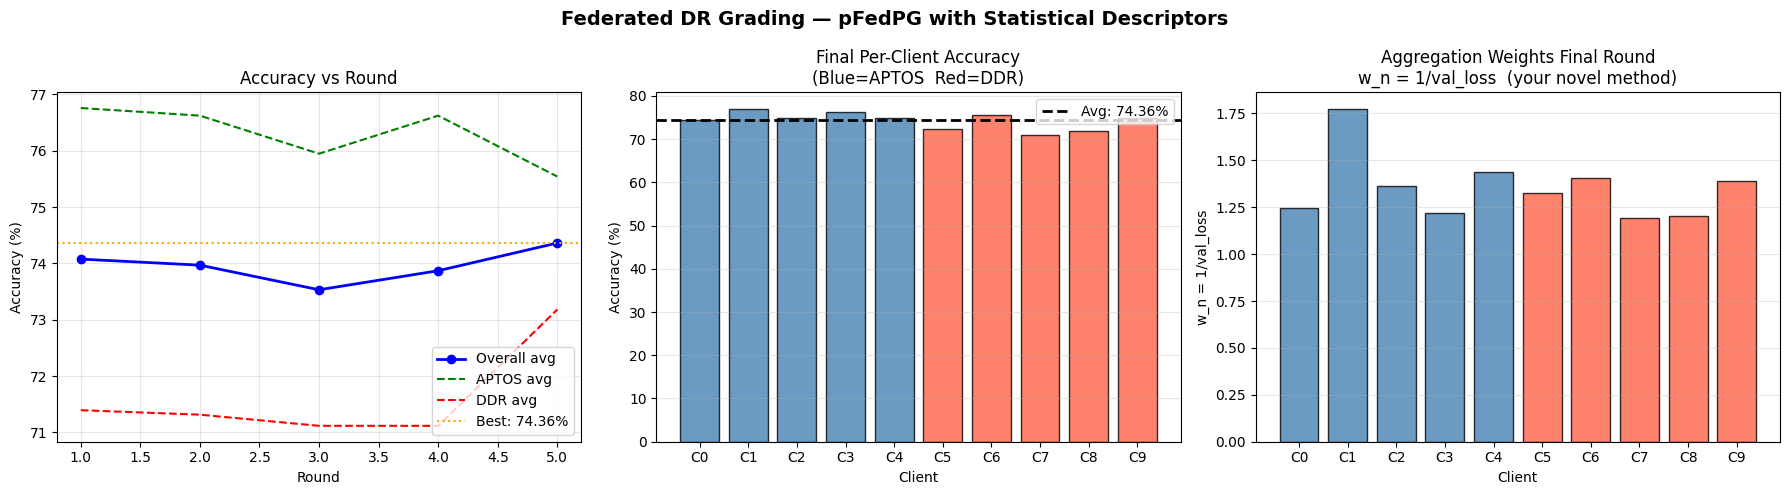

✓ Plot saved: federated_results.png


In [ ]:
# ============================================================================
# CELL 23: Visualization
# ============================================================================

import matplotlib.pyplot as plt

rounds     = [r['round']     for r in server.round_results]
avg_accs   = [r['avg_acc']   for r in server.round_results]
aptos_avgs = [r['aptos_avg'] for r in server.round_results]
ddr_avgs   = [r['ddr_avg']   for r in server.round_results]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ── Plot 1: Overall accuracy progression ──────────────────────────────
ax = axes[0]
ax.plot(rounds, avg_accs,   'b-o', linewidth=2, label='Overall avg')
ax.plot(rounds, aptos_avgs, 'g--', linewidth=1.5, label='APTOS avg')
ax.plot(rounds, ddr_avgs,   'r--', linewidth=1.5, label='DDR avg')
ax.axhline(y=best_avg_acc, color='orange', linestyle=':',
           label=f'Best: {best_avg_acc:.2f}%')
ax.set_xlabel('Round');  ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy vs Round')
ax.legend();  ax.grid(True, alpha=0.3)

# ── Plot 2: Final per-client accuracy bar chart ────────────────────────
ax = axes[1]
cids    = [f"C{i}" for i in range(len(fl_clients))]
colors  = ['steelblue'] * 5 + ['tomato'] * 5
ax.bar(cids, final['client_accs'], color=colors, alpha=0.8,
       edgecolor='black')
ax.axhline(y=final['avg_acc'], color='black', linestyle='--',
           linewidth=2, label=f"Avg: {final['avg_acc']:.2f}%")
ax.set_xlabel('Client');  ax.set_ylabel('Accuracy (%)')
ax.set_title('Final Per-Client Accuracy\n(Blue=APTOS  Red=DDR)')
ax.legend();  ax.grid(True, alpha=0.3, axis='y')

# ── Plot 3: w_n = 1/val_loss per client (final round) ─────────────────
ax = axes[2]
ax.bar(cids, final['weights'], color=colors, alpha=0.8,
       edgecolor='black')
ax.set_xlabel('Client');  ax.set_ylabel('w_n = 1/val_loss')
ax.set_title('Aggregation Weights Final Round\n'
             'w_n = 1/val_loss  (your novel method)')
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Federated DR Grading — pFedPG with Statistical Descriptors',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('federated_results.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Plot saved: federated_results.png")